In [1]:
import tensorflow as tf
import sys
from tensorflow.python import keras
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import losses
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.python.keras.optimizers import adam_v2
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras import regularizers

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tf.__version__)

Python:  3.8.10 (default, May 19 2021, 13:12:57) [MSC v.1916 64 bit (AMD64)]
pandas:  1.2.4
numpy:  1.20.2
seaborn:  0.11.1
matplotlib:  3.3.4
sklearn:  0.24.2
Keras:  2.5.0
Tensorflow:  2.5.0


In [2]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors = ["orange", "green"]
        sns.heatmap(matrix,
                    xticklabels=self.labels,
                    yticklabels=self.labels,
                    cmap=colors,
                    annot=True,
                    fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error, 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index,
                      group.error,
                      marker='x' if name == 1 else 'o',
                      linestyle='',
                      color='r' if name == 1 else 'g',
                      label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold,
                    axes.get_xlim()[0],
                    axes.get_xlim()[1],
                    colors="b",
                    zorder=100,
                    label='Threshold')
        axes.legend()

        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
        plt.plot(error, marker='o', ms=3.5, linestyle='', label='Point')

        plt.hlines(threshold,
                   xmin=0,
                   xmax=len(error) - 1,
                   colors="b",
                   zorder=100,
                   label='Threshold')
        plt.legend()
        plt.title("Reconstruction error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

In [3]:
filePath = './datasets/CreditCard.csv'
df = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=',')
print(df.shape[0])
df.head()

284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df['Amount'] = StandardScaler().fit_transform(
    df['Amount'].values.reshape(-1, 1))
df0 = df.query('Class == 0').sample(20000)
df1 = df.query('Class == 1').sample(400)
df = pd.concat([df0, df1])

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(labels=['Time', 'Class'], axis=1),
                                                    df['Class'], test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

(16320, 29) train samples
(4080, 29) test samples


In [6]:
# deep autoencoder
logfilename = "DeepAutoencoder"

encoding_dim = 16
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputArray)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(4, activation='relu')(encoded)

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='relu')(decoded)
decoded = Dense(input_dim, activation='softmax')(decoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_4 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_5 (Dense)              (None, 29)                493   

In [7]:
autoencoder.compile(optimizer=tf.keras.optimizers.RMSprop(),
                    loss='mean_squared_error',
                    metrics=['mae', 'accuracy'])

In [8]:
batch_size = 32
epochs = 20

history = autoencoder.fit(
    x_train,
    x_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    shuffle=True,
    validation_data=(x_test, x_test),
    #     callbacks=[TensorBoard(log_dir='../logs/{0}'.format(logfilename))]
)

Epoch 1/20
510/510 [==============================] - 1s 1ms/step - loss: 1.4835 - mae: 0.6784 - accuracy: 0.1965 - val_loss: 1.6848 - val_mae: 0.6859 - val_accuracy: 0.3392
Epoch 2/20
510/510 [==============================] - 0s 572us/step - loss: 1.4380 - mae: 0.6618 - accuracy: 0.4172 - val_loss: 1.6574 - val_mae: 0.6760 - val_accuracy: 0.4559
Epoch 3/20
510/510 [==============================] - 0s 575us/step - loss: 1.4248 - mae: 0.6570 - accuracy: 0.4635 - val_loss: 1.6521 - val_mae: 0.6741 - val_accuracy: 0.4669
Epoch 4/20
510/510 [==============================] - 0s 566us/step - loss: 1.4214 - mae: 0.6558 - accuracy: 0.4772 - val_loss: 1.6500 - val_mae: 0.6736 - val_accuracy: 0.4826
Epoch 5/20
510/510 [==============================] - 0s 565us/step - loss: 1.4186 - mae: 0.6551 - accuracy: 0.4910 - val_loss: 1.6489 - val_mae: 0.6729 - val_accuracy: 0.4919
Epoch 6/20
510/510 [==============================] - 0s 560us/step - loss: 1.4169 - mae: 0.6546 - accuracy: 0.4985 - val_

In [9]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

128/128 [==============================] - 0s 398us/step - loss: 1.6351 - mae: 0.6713 - accuracy: 0.5696
Test loss: 1.6351271867752075
Test accuracy: 0.6712788939476013


In [10]:
threshold = 10.00
'''
If you observe the four classification reports,
you can see that the precision and recall columns are not good
(note the very low values for precision and recall in row 0 and row 1) 
for threshold = 1 or 5.
They look better for threshold = 10 or 15.
In fact, threshold = 10 looks pretty good with a good recall
and also higher precision than for threshold = 1 or 5.
'''

y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label = []
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)

In [11]:
print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3987
           1       0.46      0.89      0.61        93

    accuracy                           0.97      4080
   macro avg       0.73      0.93      0.80      4080
weighted avg       0.99      0.97      0.98      4080



In [12]:
roc_auc_score(y_test, y_label)

0.9340720244018867

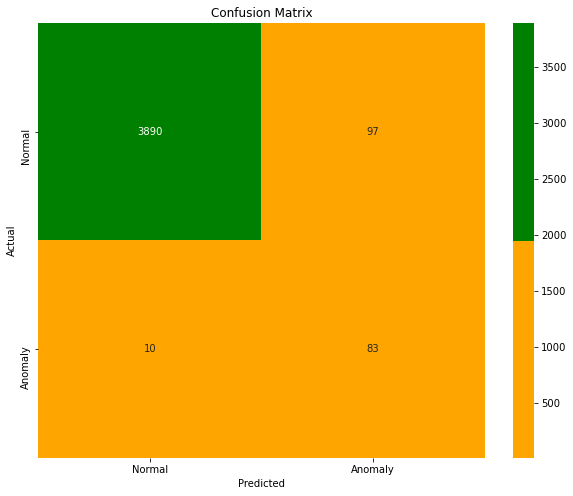

In [13]:
viz = Visualization()

viz.draw_confusion_matrix(y_test, y_label)

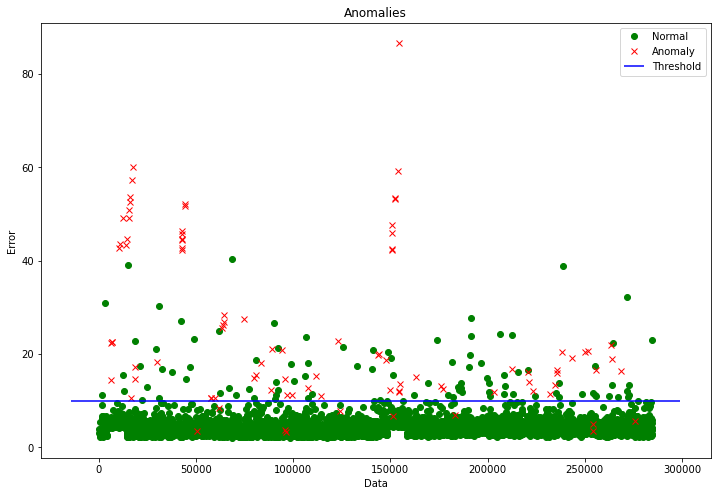

In [14]:
viz.draw_anomaly(y_test, error, threshold)